In [38]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import scipy as sp
import csv
from collections import Counter
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
np.random.seed(827)

/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/ipykernel_15563/2654920434.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


In [48]:
def readin_and_avg(rd_file, window):
    read_depths = []
    with open(rd_file) as tsv:
        for line in csv.reader(tsv, delimiter = '\t'):
            read_depths.append(int(line[-1]))
    
    read_depths = np.array(read_depths)
    mean_read_depths = np.mean(read_depths)
    log_rel_read_depths = np.log(read_depths/mean_read_depths)

    moving_avg_points = np.arange(0, log_rel_read_depths.shape[0]+window, window)

    means = []
    for i in range(moving_avg_points.shape[0]-1):
        slice = log_rel_read_depths[moving_avg_points[i]:moving_avg_points[i+1]]
        slice_avg = np.mean(slice)
        means.append(slice_avg)

    return means

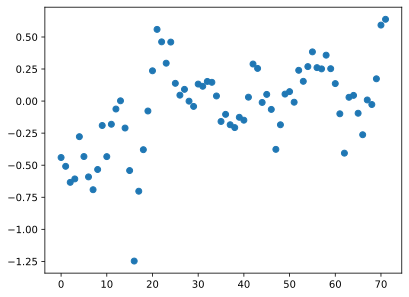

In [54]:
means = readin_and_avg('MDR1_read_depth.txt', window = 100)
means = np.array(means)
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(range(means.shape[0]), means)

In [67]:
max_cp_inference = 10

T = means.shape[0]
times_list = []
for t in range(T):
  time_list = []
  for cp in range(max_cp_inference):
    time_list.append(t)
  times_list.append(time_list)

tiled_times = np.array(times_list)
# We do this so that we can allow the Categorical prior over the changepoint
# locations to exclude the timesteps at the very beginning and very end. 
# The reason for this is that these data points always benefit from using an 
# extra changepoint just for the first or last data points. 
uniform_except_ends = np.ones(T)
uniform_except_ends[0:2] = 0
uniform_except_ends[-2:] = 0
uniform_except_ends = uniform_except_ends / uniform_except_ends.sum()

with pm.Model() as model:
  # Probability that any of the <max_cp_inference> change points are active
  p_changepoint  = pm.Beta('p_changepoint', alpha=2, beta=8)

  # Sort the changepoints for faster mixing / convergence
  changepoints = pm.Categorical('changepoints', uniform_except_ends, shape=max_cp_inference)
  is_cp_active = pm.Bernoulli('is_cp_active', p_changepoint, shape=max_cp_inference)
  #changepoints_sorted = pm.Deterministic('changepoints_sorted', torch.sort(changepoints))

  # This will give us a nice posterior estimate of the number of changepoints
  num_active_cp = pm.Deterministic('num_active_cp', pm.math.sum(is_cp_active))

  global_mean = pm.Normal('global_mean', sigma=1)
  cp_sd = pm.HalfNormal('cp_sd', sigma=2)
  noise_sd = pm.HalfNormal('noise_sd', sigma=8)
  changepoint_deltas = pm.Normal('changepoint_deltas', cp_sd, shape=max_cp_inference)

  # Operation involves operations on arrays with shape (T, max_cp_inference)
  # Elementwise operation zeros-out contributions from changepoints which are
  # not active
  is_timestep_past_cp = (tiled_times > changepoints[None, :].repeat(T, axis=0))
  active_deltas = (changepoint_deltas*is_cp_active)
  cp_contrib = pm.Deterministic('cp_contrib',
                                global_mean + pm.math.sum(is_timestep_past_cp * active_deltas, axis=1)
  )
      
  _ = pm.Normal('likelihood', mu=cp_contrib, sigma=noise_sd, observed=means)

  trace = pm.sample(draws=20_000, tune=20_000, chains=4)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_changepoint, global_mean, cp_sd, noise_sd, changepoint_deltas]
>CategoricalGibbsMetropolis: [changepoints]
>BinaryGibbsMetropolis: [is_cp_active]


/Users/jmarglou/mambaforge/envs/pymc_env/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 108 seconds.
There were 31517 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/var/folders/vk/5xl0wvxx5bs_2skg8xjzt11m0000gn/T/ipykernel_15563/1673192781.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels([0, .5, 1.0], fontsize = 10)


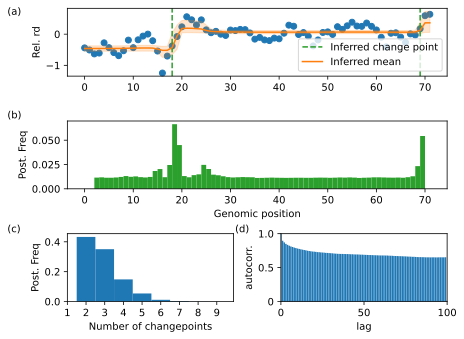

In [66]:
fig = plt.figure(tight_layout= True)

post_changepoints = trace.posterior['changepoints'].to_numpy().ravel().tolist()
num_changepoints_post_samples = trace.posterior['num_active_cp'].to_numpy().ravel().tolist()
top_2_cp = Counter(
    trace.posterior['changepoints'].to_numpy().ravel().tolist()
    ).most_common(2)

ax = fig.add_subplot(311)
for i, (t, _) in enumerate(top_2_cp):
  if i == 0:
    label = 'Inferred change point'
  else:
    label=None
  ax.axvline(t, color='C2', linestyle='--', label=label)

ax.scatter(np.arange(0, means.shape[0], 1), means, c = 'C0')

q10, q90 = np.percentile(trace.posterior['cp_contrib'], [10,90], axis=(0,1))
plt.fill_between(np.arange(T), q10, q90, color='C1', alpha=0.2)
plt.plot(trace.posterior['cp_contrib'].mean(axis=(0,1)), label='Inferred mean', color='C1')

ax.legend()
ax.set_ylabel('Rel. rd')

ax2 = fig.add_subplot(312)
ax2.set_xlabel('Genomic position')

ax2.hist(post_changepoints, bins = np.arange(0, means.shape[0], 1), density = True, color = 'C2')
ax2.set_ylabel('Post. Freq')

ax3 = fig.add_subplot(325)
ax3.hist(num_changepoints_post_samples, bins = np.arange(1.5, 10.5, 1), density = True)
ax3.set_ylabel ('Post. Freq')
ax3.set_xlabel('Number of changepoints')
ax3.set_xticks(np.arange(1, 10, 1))

ax4 = fig.add_subplot(326)
pm.plot_autocorr(trace, 'num_active_cp', combined = True, ax = ax4)
ax4.set_title('')
ax4.set_ylim([0, 1])
ax4.set_xlabel('lag')
ax4.set_ylabel("autocorr.")
ax4.set_xticks([0, 50, 100])
ax4.set_xticklabels([0, 50, 100], fontsize = 10)
ax4.set_yticklabels([0, .5, 1.0], fontsize = 10)

fig.text(s = '(a)', x = 0, y = .95 )
fig.text(s = '(b)', x = 0, y = .65 )
fig.text(s = '(c)', x = 0, y = .32 )
fig.text(s = '(d)', x = .495, y = .32 )


fig.savefig('test_data.png', dpi = 300)

In [70]:
q5, q95 = np.percentile(trace.posterior['num_active_cp'], [5,95], axis=(0,1))
print(q5, q95)
median = np.median(trace.posterior['num_active_cp'])
print(median)

1.0 5.0
2.0
